In [1]:
import folium
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from itertools import islice

---
# Data Import
---

### Read the airlines data with all the flights from src to dest

In [2]:
airlines_data = pd.read_csv("data/airlines.csv")
airlines_data = airlines_data[["src_name", "src_id", "dest_name", "dest_id"]]
airlines_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   src_name   67663 non-null  object
 1   src_id     67663 non-null  object
 2   dest_name  67663 non-null  object
 3   dest_id    67663 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


### Read aiports data with corresponding latitude, longitude and altitude

In [3]:
airports_data = pd.read_csv("data/airports.csv")
airports_data = airports_data[["id", "name", "latitude", "longitude", "airport", "city", "country"]]
airports_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12668 entries, 0 to 12667
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         12668 non-null  int64  
 1   name       12668 non-null  object 
 2   latitude   12668 non-null  float64
 3   longitude  12668 non-null  float64
 4   airport    12668 non-null  object 
 5   city       12619 non-null  object 
 6   country    12668 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 692.9+ KB


---
# Data Analysis (Part I) - Data Processing and Cleaning
---

### Fill the "\N" values of the airlines dataset and cast object columns to int64

In [4]:
name_to_id_mapping = pd.Series(airports_data["id"].values, index=airports_data["name"]).to_dict()
airlines_data.replace({"\\N": pd.NA}, inplace=True)
airlines_data["src_id"] = airlines_data["src_id"].fillna(airlines_data["src_name"].map(name_to_id_mapping))
airlines_data["dest_id"] = airlines_data["dest_id"].fillna(airlines_data["dest_name"].map(name_to_id_mapping))
airlines_data.dropna(inplace=True)
airlines_data["src_id"] = airlines_data["src_id"].astype(np.int64)
airlines_data["dest_id"] = airlines_data["dest_id"].astype(np.int64)
airlines_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67572 entries, 0 to 67662
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   src_name   67572 non-null  object
 1   src_id     67572 non-null  int64 
 2   dest_name  67572 non-null  object
 3   dest_id    67572 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


### Merge the datasets and get the latitude and longitude for both source and destination airports

In [5]:
data = pd.merge(airlines_data, airports_data, left_on=["src_name"], right_on=["name"], how="left")
data = data.rename(columns={"latitude" : "src_latitude", "longitude": "src_longitude"})[["src_id", "src_name", "src_latitude", "src_longitude", "dest_id", "dest_name"]]
data = pd.merge(data, airports_data, left_on=["dest_name"], right_on=["name"], how="left")
data = data.rename(columns={"latitude" : "dest_latitude", "longitude": "dest_longitude"})[["src_id", "src_name", "src_latitude", "src_longitude", "dest_id", "dest_name", "dest_latitude", "dest_longitude"]]
data.dropna(inplace=True)
data

,src_id,src_name,src_latitude,src_longitude,dest_id,dest_name,dest_latitude,dest_longitude
0,2965,AER,43.449902,39.956600,2990,KZN,55.606201,49.278702
1,2966,ASF,46.283298,48.006302,2990,KZN,55.606201,49.278702
2,2966,ASF,46.283298,48.006302,2962,MRV,44.225101,43.081902
3,2968,CEK,55.305801,61.503300,2990,KZN,55.606201,49.278702
4,2968,CEK,55.305801,61.503300,4078,OVB,55.012600,82.650703
...,...,...,...,...,...,...,...,...
67567,6334,WYA,-33.058899,137.514008,3341,ADL,-34.945000,138.531006
67568,4029,DME,55.408798,37.906300,2912,FRU,43.061298,74.477600
67569,2912,FRU,43.061298,74.477600,4029,DME,55.408798,37.906300
67570,2912,FRU,43.061298,74.477600,2913,OSS,40.609001,72.793297


### Counting the occurrences of each source name

In [6]:
src_count = data["src_name"].value_counts().reset_index()
src_count.columns = ["name", "count"]
src_count

,name,count
0,ATL,915
1,ORD,558
2,LHR,527
3,PEK,527
4,CDG,524
...,...,...
3351,OGS,1
3352,OLF,1
3353,YGZ,1
3354,PVC,1


### Counting the occurrences of each destination name

In [7]:
dest_count = data["dest_name"].value_counts().reset_index()
dest_count.columns = ["name", "count"]
dest_count

,name,count
0,ATL,911
1,ORD,550
2,PEK,527
3,LHR,524
4,CDG,517
...,...,...
3359,OER,1
3360,ESL,1
3361,OGL,1
3362,PES,1


### Removing duplicate routes and self-loops

In [8]:
initial_count = len(data)
data = data.drop_duplicates(subset=['src_name', 'dest_name'])
final_count = len(data)
print(f"Removed {initial_count - final_count} duplicate routes.")

initial_count = len(data)
data = data[data['src_name'] != data['dest_name']]
final_count = len(data)
print(f"Removed {initial_count - final_count} self-looped routes.")

Removed 29986 duplicate routes.
Removed 1 self-looped routes.


---
# Visualization (Part I) - Total Dataset
---

In [9]:
def save(obj, name, index):
    obj.save(f"vis{index}_{name}.html")

In [10]:
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for _, route in data.iterrows():
    folium.PolyLine([(route["src_latitude"], route["src_longitude"]), (route["dest_latitude"], route["dest_longitude"])], color="cyan", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "total_dataset", 1)

---
# Node Analysis (Part I) - Building the graph and processing
---

### Build the Directed Graph
Nodes represent airports and edges represent a route between two airports

In [11]:
G = nx.DiGraph()
for idx, row in data.iterrows():
    G.add_edge(row['src_name'], row['dest_name'], weight=1)
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Nodes: 3373
Edges: 37406


### Outlier Identification and Removal
In the context of directed graphs, especially those representing real-world networks, outliers can significantly impact the analysis. Outliers in such networks can be nodes that disrupt the flow or connectivity of the graph. Specifically, for our domain of transportation networks, outliers can be:

- Dangling Nodes (Sink Nodes): These are nodes where routes end (i.e., they have in-edges but no out-edges). They can be thought of as terminal destinations with no outgoing routes.
- Source Nodes: These are nodes where routes begin (i.e., they have out-edges but no in-edges). They represent origins with no incoming routes.
- Isolated Nodes: Nodes that are completely disconnected from the rest of the network, having neither in-edges nor out-edges.

The removal of such outliers can help in obtaining a more connected and robust network, which is essential for subsequent analyses like shortest paths and network robustness.

In [12]:
def identify_outliers(graph):
    in_deg = dict(graph.in_degree())
    out_deg = dict(graph.out_degree())
    dangling_nodes = [node for node, outdegree in out_deg.items() if outdegree == 0]
    source_nodes = [node for node, indegree in in_deg.items() if indegree == 0]
    isolated_nodes = [node for node in graph.nodes() if in_deg[node] == 0 and out_deg[node] == 0]
    return list(set(dangling_nodes + source_nodes + isolated_nodes))

iterations = 0
num_outliers = 0
while True:
    outliers = identify_outliers(G)
    if not outliers:
        break
    G.remove_nodes_from(outliers)
    iterations += 1
    num_outliers += len(outliers)

print(f"Outliers removed: {num_outliers}")
print(f"Remaining Nodes: {G.number_of_nodes()}")
print(f"Remaining Edges: {G.number_of_edges()}")

Outliers removed: 39
Remaining Nodes: 3334
Remaining Edges: 37362


### Extracting the largest strongly connected subgraph

In [13]:
scc = list(nx.strongly_connected_components(G))
scc_sorted = sorted(scc, key=len, reverse=True)
largest_scc = scc_sorted[0]
G = G.subgraph(largest_scc)

print(f"Number of nodes in the largest SCC: {G.number_of_nodes()}")
print(f"Number of edges in the largest SCC: {G.number_of_edges()}")

Number of nodes in the largest SCC: 3300
Number of edges in the largest SCC: 37301


---
# Visualization (Part II) - Largest Strongly Connected Component
---


In [14]:
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for src, dest in G.edges():
    src_info = airports_data.loc[airports_data["name"] == src].iloc[0]
    dest_info = airports_data.loc[airports_data["name"] == dest].iloc[0]
    folium.PolyLine([(src_info["latitude"], src_info["longitude"]), (dest_info["latitude"], dest_info["longitude"])], color="cyan", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "largest_scc", 2)

---
# Node Analysis Part (II) - Initial Metrics and Plots
---

### Average Degree
Calculate the in-degree and out-degree)
The average in-degree and out-degree are the same, this is actually an expected property of directed graphs, and it's based on the Handshaking Lemma. When we calculate the average in-degree and out-degree, we divide the total in-degree and out-degree by the number of nodes, respectively. Since the total in-degree and out-degree are equal (as per the lemma), their averages will also be equal. Thus, in any directed graph, the average in-degree is always equal to the average out-degree.

In [15]:
in_degrees = [deg for node, deg in G.in_degree()]
out_degrees = [deg for node, deg in G.out_degree()]

avg_in_degree = sum(in_degrees) / len(in_degrees)
avg_out_degree = sum(out_degrees) / len(out_degrees)

print(f"Average In-Degree: {avg_in_degree}")
print(f"Average Out-Degree: {avg_out_degree}")

Average In-Degree: 11.303333333333333
Average Out-Degree: 11.303333333333333


### Degree Rank
Provides a visualization of the degrees of nodes within the network, ordered from the highest to the lowest. The x-axis represents the rank of each node (from the highest degree to the lowest), while the y-axis represents the degree of nodes. This plot is useful for quickly identifying the nodes with the highest degrees and observing the degree variability within the network. A steep curve indicates a few nodes have significantly higher degrees than the rest, which might suggest a scale-free network.

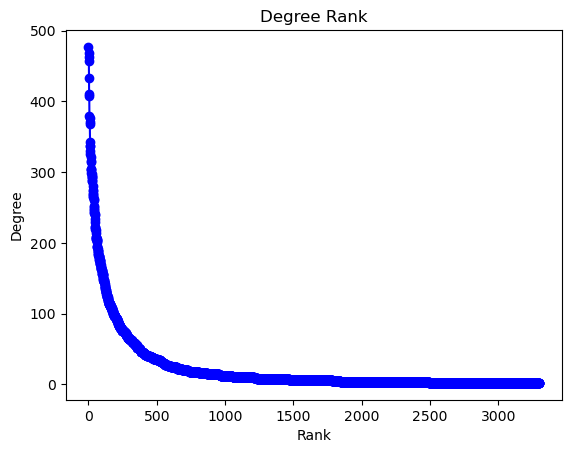

In [16]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank")
plt.ylabel("Degree")
plt.xlabel("Rank")
plt.show()

### Degree Distribution
Illustrates the distribution of node degrees across the entire network. The x-axis represents the degree k of nodes, and the y-axis represents the frequency or probability of nodes having degree k. This histogram provides insights into the commonality of nodes with certain degrees, enabling you to identify the most common and rare node degrees within the network. Peaks in the histogram indicate degrees that are more prevalent in the network.

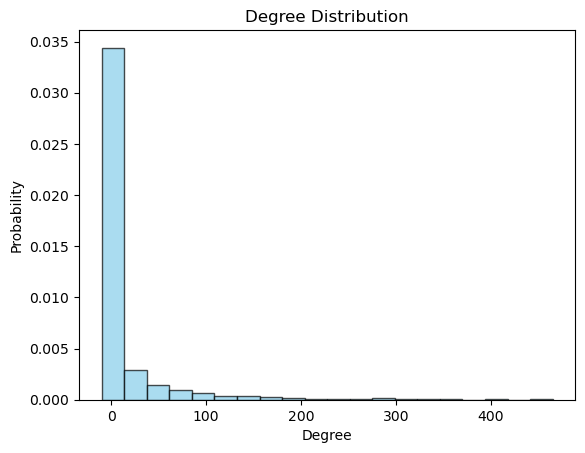

In [17]:
hist, bins = np.histogram(degree_sequence, bins=20, density=True)
plt.bar(bins[:-1], hist, width=np.diff(bins), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

### Log-Log Degree Rank
It is a log-log plot of the degree distribution of the network. Both axes are on a logarithmic scale. The x-axis represents the degree k of nodes, and the y-axis represents the frequency or probability of nodes having degree k. This plot is particularly useful for identifying whether the degree distribution follows a power-law distribution, which is a common property of scale-free networks. A straight line on a log-log scale indicates a power-law distribution, while deviations from this can highlight interesting properties or anomalies in the network.

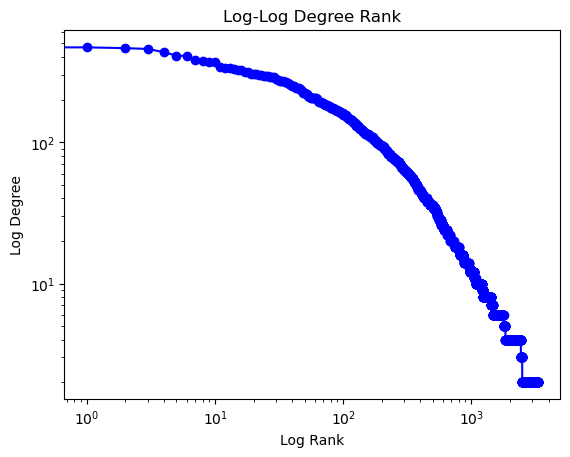

In [18]:
plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Log-Log Degree Rank")
plt.xlabel("Log Rank")
plt.ylabel("Log Degree")
plt.show()

### Cumulative Log-Log Degree Rank
It visualizes the cumulative degree distribution of the network on a log-log scale. The x-axis represents the degree k of nodes, and the y-axis represents the cumulative probability (≥) P(K≥k) that a node has a degree larger than or equal to k. This plot is especially useful for analyzing the tail behavior of the degree distribution, particularly in networks with heavy-tailed or power-law degree distributions. A smoother curve in the cumulative plot, as compared to the non-cumulative version, often provides a clearer visualization of the tail and can be more amenable to regression analysis for identifying power-law exponents.

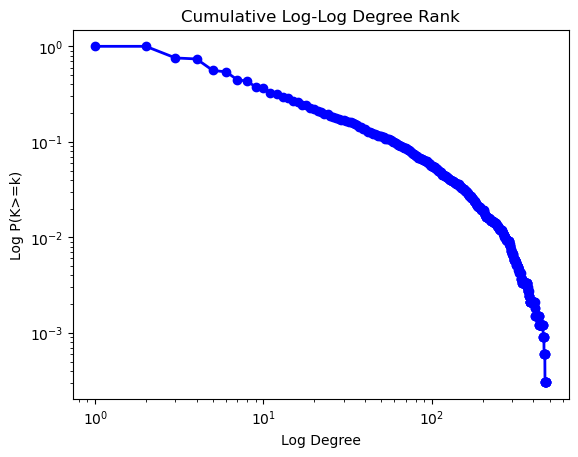

In [19]:
hist, bin_edges = np.histogram(degree_sequence, bins=np.arange(1, np.max(degree_sequence)+2), density=True)
cumulative_dist = np.cumsum(hist[::-1])[::-1]
plt.loglog(bin_edges[:-1], cumulative_dist, 'bo-', linewidth=2)
plt.title("Cumulative Log-Log Degree Rank")
plt.xlabel("Log Degree")
plt.ylabel("Log P(K>=k)")
plt.show()

---
# Visualization (Part II) - Top 10 nodes with Highest Degree
---
In this visualization, we will focus on the top 10 airports with the highest degree, omitting the visualization of all routes to enhance clarity and focus on these key hubs. Each airport will be represented by a marker, and the routes originating from these airports will be depicted by lines on the map. Different colors will be assigned to each airport and its respective routes for clear differentiation and analysis. This visualization will provide insights into the connectivity and network structure of the most central airports, which can be pivotal for strategic planning, route optimization, and understanding the flow and distribution of air traffic across the network.

In [20]:
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, degree) in enumerate(top_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    popup_text = f"""
    <strong>Rank:</strong> {idx + 1}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Degree:</strong> {degree}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon],
                  popup=popup,
                  icon=folium.Icon(color="red")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="red", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "top_nodes_by_degree", 3)

---
# Visualization (Part III) - Centrality Analysis
---

### Degree Centrality
Degree centrality is a measure that defines the relative importance of a node within a network. It is calculated as the number of links incident upon a node (i.e., the number of ties that a node has). In the context of our flight routes network, a high degree centrality for an airport would imply that it is connected to a large number of other airports, making it a crucial hub in the network. Visualizing the degree centrality of the top nodes (airports) can provide insights into the primary hubs in the global flight network and their respective importance in terms of connectivity.

In [21]:
degree_centrality = nx.degree_centrality(G)
top_centrality_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_centrality_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    popup_text = f"""
    <strong>Rank:</strong> {idx + 1}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Degree Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon],
                  popup=popup,
                  icon=folium.Icon(color="orange")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="orange", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "degree_centrality", 4)

### Eigenvector Centrality
Eigenvector centrality is a measure that identifies nodes with high influence in a network, considering not only their direct connections but also the quality of these connections. In the context of our air traffic network, a high eigenvector centrality would indicate an airport (node) that is not only connected to many other airports but is also connected to well-connected airports. This can suggest that the airport is a significant connector in high-traffic routes and potentially a crucial point in the network for maintaining connectivity among various airports.

In the visualization below, we will focus on the top 10 airports based on their eigenvector centrality scores. These airports can be considered as influential nodes in the network, ensuring that traffic can flow through well-connected paths. The map will display routes related to these top 10 airports, and each marker will provide detailed information about the airport, including its rank based on eigenvector centrality, name, city, country, and the exact centrality score.

In [22]:
eigenvector_centrality = nx.eigenvector_centrality(G)
top_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_eigenvector_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    popup_text = f"""
    <strong>Rank:</strong> {idx + 1}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Eigenvector Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon],
                  popup=popup,
                  icon=folium.Icon(color="green")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="lime", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "eigenvector_centrality", 5)        

### Katz Centrality
Katz Centrality measures the relative influence of a node within a network. It takes into account the immediate neighbors of a node and also all the other nodes in the network that connect to the node through these neighbors. It uses an attenuation factor to give more importance to nodes closer to the node in question.

In [23]:
katz_centrality = nx.katz_centrality(G, alpha=0.005, max_iter=2000)
top_katz_nodes = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_katz_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    rank = idx + 1
    popup_text = f"""
    <strong>Rank:</strong> {rank}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Katz Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon], popup=popup, icon=folium.Icon(color="blue")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="cyan", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "katz_centrality", 6)

### PageRank Centrality
PageRank is an algorithm originally used by Google Search to rank web pages in their search engine results. It works by counting the number and quality of links to a page to determine a rough estimate of the website's importance. In the context of your network, it can be used to determine the relative importance of each airport.

In [24]:
pagerank_centrality = nx.pagerank(G)
top_pagerank_nodes = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_pagerank_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    rank = idx + 1
    popup_text = f"""
    <strong>Rank:</strong> {rank}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>PageRank Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon], popup=popup, icon=folium.Icon(color="green")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="cyan", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "pagerank_centrality", 7)

### Closeness Centrality
Closeness centrality is a measure that indicates how close a node is to all other nodes in the network. In the context of our air traffic network, an airport with high closeness centrality can be interpreted as an airport that is, on average, relatively close to all other airports in the network in terms of the number of hops (transfers) required to reach any other airport. This could imply that such an airport can be a strategic location for minimizing travel times or transfer counts for passengers, potentially making it a favorable hub in the network.

In the visualization that follows, we will spotlight the top 10 airports based on their closeness centrality scores. These airports are, on average, fewer stops away from all other airports, suggesting that they can serve as efficient transfer points within the air traffic network. The map will illustrate routes related to these top 10 airports, and each marker will provide detailed information about the airport, including its rank based on closeness centrality, name, city, country, and the exact centrality score.

In [25]:
closeness_centrality = nx.closeness_centrality(G)
top_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_closeness_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    popup_text = f"""
    <strong>Rank:</strong> {idx + 1}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Closeness Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon],
                  popup=popup,
                  icon=folium.Icon(color="purple")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="magenta", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "closeness_centrality", 8)        

### Betweenness Centrality
Betweenness centrality is a measure that quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. In the context of our air traffic network, an airport with high betweenness centrality serves as a critical transfer or stopover point for many routes between other airports. Such an airport can be considered as a significant connector or hub within the network, facilitating the flow of traffic between various other airports.

In the upcoming visualization, we will focus on the top 10 airports with the highest betweenness centrality scores. These airports are pivotal in connecting different parts of the air traffic network, and disruptions in their operations could potentially have a cascading effect on the overall network connectivity. The map will display routes related to these top 10 airports, and each marker will provide detailed information about the airport, including its rank based on betweenness centrality, name, city, country, and the exact centrality score.

In [26]:
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, centrality) in enumerate(top_betweenness_nodes):
    info = airports_data.loc[airports_data["name"] == node].iloc[0]
    lat, lon = info["latitude"], info["longitude"]
    airport, city, country = info["airport"], info["city"], info["country"]
    popup_text = f"""
    <strong>Rank:</strong> {idx + 1}<br>
    <strong>Airport:</strong> {airport}<br>
    <strong>City:</strong> {city}<br>
    <strong>Country:</strong> {country}<br>
    <strong>Betweenness Centrality:</strong> {centrality:.4f}
    """
    popup = folium.Popup(popup_text, max_width=300)
    folium.Marker(location=[lat, lon],
                  popup=popup,
                  icon=folium.Icon(color="darkpurple")).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color="darkpurple", weight=0.1, opacity=0.5).add_to(vis)
save(vis, "betweenness_centrality", 9)

---
# Node Analysis (Part III) - Robustness and Vulnerabilities
---

### Average Shortest Path Length

The average shortest path length provides an insight into the network's efficiency. A smaller average indicates that nodes can, on average, reach each other in fewer steps, suggesting a more efficient network.


In [29]:
avg_shortest_path_length = nx.average_shortest_path_length(G)
print(f"Average Shortest Path Length: {avg_shortest_path_length}")

Average Shortest Path Length: 4.056225302433244


### Random Failures: Impact on Average Shortest Path Length

In this analysis, we simulate random failures and observe their impact on the average shortest path length of the network. The average shortest path length is a crucial metric that indicates the average number of steps required to travel between any two nodes in the network. An increase in this metric suggests reduced efficiency and connectivity in the network.

Number of nodes removed for Random: 14


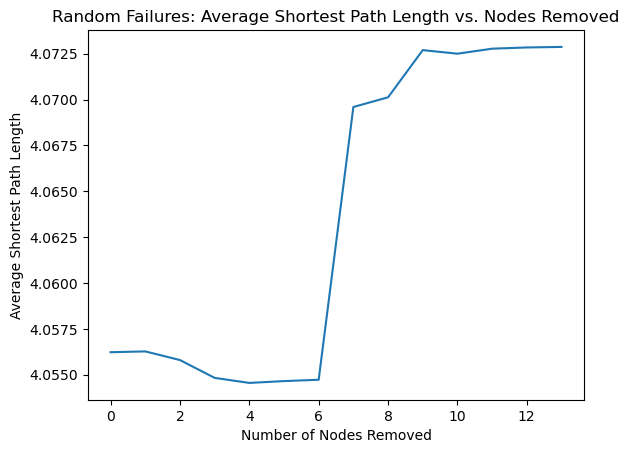

In [41]:
def random_failure_avg_shortest_path(graph):
    G_temp = graph.copy()
    avg_shortest_paths = []
    while nx.is_strongly_connected(G_temp):
        avg_shortest_paths.append(nx.average_shortest_path_length(G_temp))
        node = np.random.choice(list(G_temp.nodes()))
        G_temp.remove_node(node)
    print(f"Number of nodes removed for Random: {len(avg_shortest_paths)}")
    return avg_shortest_paths

avg_shortest_paths = random_failure_avg_shortest_path(G)

plt.plot(avg_shortest_paths)
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Average Shortest Path Length')
plt.title('Random Failures: Average Shortest Path Length vs. Nodes Removed')
plt.show()

### Random Failures: Impact on the Size of the Largest Strongly Connected Component

In this analysis, we simulate random failures by removing nodes at random and observe their impact on the size of the largest strongly connected component (LSCC) of the network. Random failures can lead to fragmentation of the network, reducing its overall connectivity.

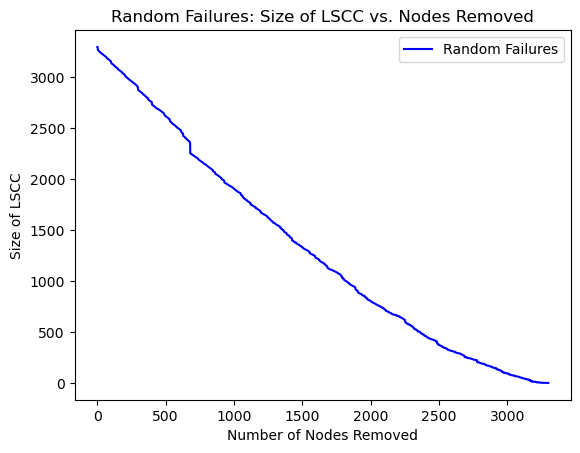

In [42]:
def random_failure_lscc_size(graph):
    G_temp = graph.copy()
    nodes = list(G_temp.nodes())
    np.random.shuffle(nodes)
    lscc_sizes = []
    while nodes:
        lscc_sizes.append(len(max(nx.strongly_connected_components(G_temp), key=len)))
        node = nodes.pop()
        G_temp.remove_node(node)
    return lscc_sizes

lscc_sizes_random = random_failure_lscc_size(G)
plt.plot(range(len(lscc_sizes_random)), lscc_sizes_random, label='Random Failures', color='blue')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of LSCC')
plt.title('Random Failures: Size of LSCC vs. Nodes Removed')
plt.legend()
plt.show()

### Targeted Attacks: Impact on Average Shortest Path Length

In this analysis, we simulate targeted attacks based on various node centrality measures and observe their impact on the average shortest path length of the network. Targeted attacks, especially on high centrality nodes, can significantly disrupt the network's connectivity and efficiency. We'll analyze the effects using the following centrality measures:
- Degree Centrality
- Eigenvector Centrality
- Katz Centrality
- PageRank Centrality
- Closeness Centrality
- Betweenness Centrality

Number of nodes removed for Degree Centrality: 4
Number of nodes removed for Eigenvector Centrality: 6
Number of nodes removed for Katz Centrality: 4
Number of nodes removed for PageRank Centrality: 1
Number of nodes removed for Closeness Centrality: 4
Number of nodes removed for Betweenness Centrality: 1


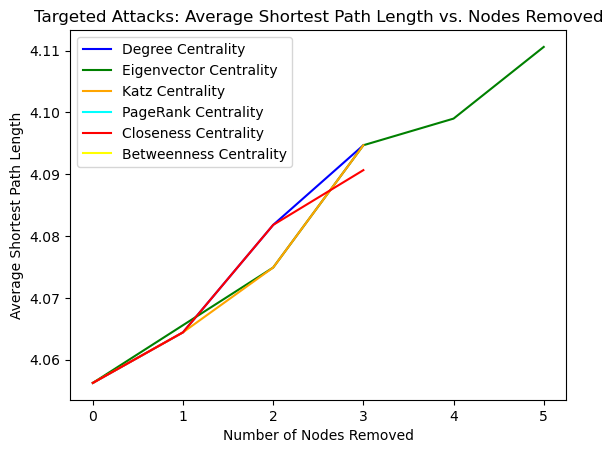

In [44]:
def targeted_attack_avg_shortest_path(graph, centrality_measure, centrality_name):
    G_temp = graph.copy()
    nodes_sorted_by_centrality = sorted(centrality_measure, key=centrality_measure.get, reverse=True)
    avg_shortest_paths = []
    while nx.is_strongly_connected(G_temp):
        avg_shortest_paths.append(nx.average_shortest_path_length(G_temp))
        node = nodes_sorted_by_centrality.pop(0)
        G_temp.remove_node(node)
    print(f"Number of nodes removed for {centrality_name}: {len(avg_shortest_paths)}")
    return avg_shortest_paths

avg_shortest_paths_degree = targeted_attack_avg_shortest_path(G, degree_centrality, 'Degree Centrality')
plt.plot(avg_shortest_paths_degree, label='Degree Centrality', color='blue')

avg_shortest_paths_eigenvector = targeted_attack_avg_shortest_path(G, eigenvector_centrality, 'Eigenvector Centrality')
plt.plot(avg_shortest_paths_eigenvector, label='Eigenvector Centrality', color='green')

avg_shortest_paths_katz = targeted_attack_avg_shortest_path(G, katz_centrality, 'Katz Centrality')
plt.plot(avg_shortest_paths_katz, label='Katz Centrality', color='orange')

avg_shortest_paths_pagerank = targeted_attack_avg_shortest_path(G, pagerank_centrality, 'PageRank Centrality')
plt.plot(avg_shortest_paths_pagerank, label='PageRank Centrality', color='cyan')

avg_shortest_paths_closeness = targeted_attack_avg_shortest_path(G, closeness_centrality, 'Closeness Centrality')
plt.plot(avg_shortest_paths_closeness, label='Closeness Centrality', color='red')

avg_shortest_paths_betweenness = targeted_attack_avg_shortest_path(G, betweenness_centrality, 'Betweenness Centrality')
plt.plot(avg_shortest_paths_betweenness, label='Betweenness Centrality', color='yellow')

plt.xlabel('Number of Nodes Removed')
plt.ylabel('Average Shortest Path Length')
plt.title('Targeted Attacks: Average Shortest Path Length vs. Nodes Removed')
plt.legend()
plt.show()

### Targeted Attacks: Impact on the Size of the Largest Strongly Connected Component

In this analysis, we simulate targeted attacks based on various centrality measures and observe their impact on the size of the largest strongly connected component (LSCC) of the network. Targeted attacks, especially on high centrality nodes, can lead to significant fragmentation of the network.

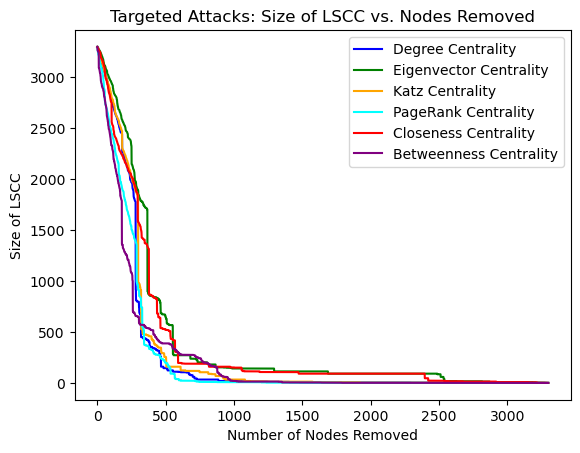

In [45]:
def targeted_attack_lscc_size(graph, centrality_measure):
    G_temp = graph.copy()
    nodes_sorted_by_centrality = sorted(centrality_measure, key=centrality_measure.get, reverse=True)
    lscc_sizes = []
    while nodes_sorted_by_centrality:
        lscc_sizes.append(len(max(nx.strongly_connected_components(G_temp), key=len)))
        node = nodes_sorted_by_centrality.pop(0)
        G_temp.remove_node(node)
    return lscc_sizes

lscc_sizes_degree = targeted_attack_lscc_size(G, degree_centrality)
plt.plot(range(len(lscc_sizes_degree)), lscc_sizes_degree, label='Degree Centrality', color='blue')

lscc_sizes_eigenvector = targeted_attack_lscc_size(G, eigenvector_centrality)
plt.plot(range(len(lscc_sizes_eigenvector)), lscc_sizes_eigenvector, label='Eigenvector Centrality', color='green')

lscc_sizes_katz = targeted_attack_lscc_size(G, katz_centrality)
plt.plot(range(len(lscc_sizes_katz)), lscc_sizes_katz, label='Katz Centrality', color='orange')

lscc_sizes_pagerank = targeted_attack_lscc_size(G, pagerank_centrality)
plt.plot(range(len(lscc_sizes_pagerank)), lscc_sizes_pagerank, label='PageRank Centrality', color='cyan')

lscc_sizes_closeness = targeted_attack_lscc_size(G, closeness_centrality)
plt.plot(range(len(lscc_sizes_closeness)), lscc_sizes_closeness, label='Closeness Centrality', color='red')

lscc_sizes_betweenness = targeted_attack_lscc_size(G, betweenness_centrality)
plt.plot(range(len(lscc_sizes_betweenness)), lscc_sizes_betweenness, label='Betweenness Centrality', color='purple')

plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of LSCC')
plt.title('Targeted Attacks: Size of LSCC vs. Nodes Removed')
plt.legend()
plt.show()

---
# Node Analysis (Part IV) - Cascading Effect and Avalanches
---

---
# Node Analysis (Part V) - Clustering Analysis
---

### Clustering Coefficient
Measures the degree to which nodes in a graph tend to cluster together

In [ ]:
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering}")

### Visualization of Top 10 Communities
In this section, we visualize the top 10 largest communities detected in our airline network. Each community represents a cluster of airports that are more densely connected with each other than with airports outside the community. This can provide insights into regional or functional groupings within the global airline network.

The map below displays these communities using distinct colors for each group. By examining the geographical distribution of these colors, we can gain an understanding of the spatial structure and connectivity patterns of the airline network.

In [ ]:
# Assuming G is your directed graph
k = 10  # desired number of communities
comp = community.girvan_newman(G)
limited = islice(comp, k-1, k)
communities = list(next(limited))

# Visualizing the communities
colors = ['yellow', 'cyan', 'blue', 'lime', 'green', 'magenta', 'pink', 'purple', 'red', 'darkred']
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")

for idx, community in enumerate(communities):
    color = colors[idx % len(colors)]
    for node in community:
        info = airports_data.loc[airports_data["name"] == node].iloc[0]
        lat, lon = info["latitude"], info["longitude"]
        folium.CircleMarker(location=(lat, lon),
                            radius=5,
                            color=color,
                            fill=True,
                            fill_opacity=0.6).add_to(vis)

save(vis, "girvan_newman_communities_visualization", 11)

In [ ]:
partition = community_louvain.best_partition(G.to_undirected())
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)
sorted_communities = sorted(communities.values(), key=len, reverse=True)
top_10_communities = sorted_communities[:10]
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
colors = ['red', 'blue', 'brown', 'purple', 'orange', 'lime', 'magenta', 'cyan', 'yellow', 'white']
for idx, community in enumerate(top_10_communities):
    for node in community:
        info = airports_data.loc[airports_data["name"] == node].iloc[0]
        lat, lon = info["latitude"], info["longitude"]
        folium.CircleMarker(location=(lat, lon),
                            radius=3,
                            color=colors[idx],
                            fill=True,
                            fill_opacity=0.5).add_to(vis)
save(vis, "top_communities", 10)

### Metrics for Top 10 Communities
After visualizing the communities, it's essential to quantify their characteristics to understand their significance in the network better. For each of the top 10 communities, we compute the following metrics:
- Average Degree: This represents the average number of connections each airport in the community has. A higher average degree indicates a denser community.
- Density: This metric provides the proportion of potential connections that exist in the community. A density value close to 1 indicates a highly interconnected community.
- Diameter: The maximum shortest path length between any two airports in the community. It gives an idea of the community's "spread."
- Average Clustering Coefficient: This measures the degree to which airports in the community tend to cluster together. A higher value indicates a tendency for airports to form tightly-knit groups.
- Average Shortest Path Length: This represents the average number of steps required to travel between any two airports in the community.

By analyzing these metrics, we can gain deeper insights into the structural and functional roles of these communities within the global airline network.

In [ ]:
for idx, community in enumerate(top_10_communities):
    subgraph = G.subgraph(community)
    avg_degree = sum(dict(subgraph.degree()).values()) / len(community)
    density = nx.density(subgraph)
    largest_scc = max(nx.strongly_connected_components(subgraph), key=len)
    scc_subgraph = subgraph.subgraph(largest_scc)
    diameter = "Not strongly connected"
    avg_shortest_path_length = "Not strongly connected"
    if scc_subgraph:
        diameter = nx.diameter(scc_subgraph)
        avg_shortest_path_length = nx.average_shortest_path_length(scc_subgraph)
    avg_clustering = nx.average_clustering(subgraph.to_undirected())
    print(f"Metrics for Community {str.capitalize(colors[idx])}:")
    print(f"Average Degree: {avg_degree:.2f}")
    print(f"Density: {density:.4f}")
    print(f"Diameter: {diameter}")
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Average Shortest Path Length: {avg_shortest_path_length}")
    print("------------------------------------------------")

Analise de robustez retirando um nó e analisar a nivel mundial e a nivel de continente
Disseminaçao de doenças usando sigmodel e utilizando os degree centrality measures


Assortativity: Measure the similarity of connections in the network with respect to the node degree.

Network Resilience: Analyze how the network structure is affected by the removal of nodes or edges, which could simulate disruptions in the airline network.


2. High Traffic Routes:
Description: Highlighting the routes (edges) that have the highest traffic or frequency can illustrate the main airline corridors.
Visualization: You might use thicker or differently colored lines to represent these high-traffic routes on the map.
3. Geographical Clusters:
Description: Identifying and visualizing clusters of nodes that are tightly connected can reveal regional airline networks.
Visualization: You might use different colors for nodes and edges that belong to different clusters.
Visualization: Highlighting these nodes can reveal airports that, while not necessarily having the highest degree, play a crucial role in connecting different parts of the network.
5. Community Structures:
Description: Visualizing community structures can reveal groups of nodes that are more densely connected with each other than with the rest of the network.
Visualization: Different communities might be visualized using different colors or shapes for nodes and edges.
6. Disconnected Components:
Description: Identifying and visualizing disconnected components of the network can reveal isolated sub-networks within the airline routes.
Visualization: Different components might be visualized using different colors.
7. Shortest Paths:
Description: Visualizing the shortest paths between selected major airports might provide insights into the efficiency and connectivity of the network.
Visualization: Highlighting the shortest path routes with distinct line styles or colors.
8. Vulnerability Analysis:
Description: Identifying and visualizing nodes whose removal would significantly disrupt the network can highlight vulnerabilities in the airline route network.
Visualization: Such nodes might be visualized with specific markers or colors.